<a href="https://colab.research.google.com/github/DmitriyKolesnikM8O/ML/blob/main/hw3/hw3_unsupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# hw3: Обучение без учителя

*Спасибо ещё одному великому курсу mlcourse.ai и авторам: Ольга Дайховская (@aiho в Slack ODS), Юрий Кашницкий (@yorko в Slack ODS).*

### О задании

В этом задании мы разберемся с тем, как работают методы снижения размерности и кластеризации данных. Заодно еще раз попрактикуемся в
задаче классификации.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице.

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации.

**Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы, выделив ответ полужирным** (``` **выделить двойными звёздочками** ```).

### Оценивание и штрафы
Вам необходимо ответить на 10 вопросов и выполнить 2 задания. Каждое из заданий и вопросов имеет определенную «стоимость» (указана в скобках). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw3-unsupervised.ipynb``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце "hw3" в строке со своей фамилией о том, что вы выполнили работу и оставить ссылку на ноутбук.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt

plt.style.use(['seaborn-v0_8-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [3]:
X_train = np.loadtxt("X_train.txt")
y_train = np.loadtxt("y_train.txt").astype(int)

X_test = np.loadtxt("X_test.txt")
y_test = np.loadtxt("y_test.txt").astype(int)

In [4]:
# Проверим размерности
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*.

In [6]:
# Ваш код здесь
X = np.vstack([X_train, X_test])
y = np.hstack([y_train, y_test])

Определим число уникальных значений меток целевого класса.

In [7]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [8]:
n_classes = np.unique(y).size

[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбе
- 2 - подъему вверх по лестнице
- 3 - спуску по лестнице
- 4 - сидению
- 5 - стоянию
- 6 - лежанию

*уж простите, если звучание этих существительных кажется корявым :)*

Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [10]:
# Ваш код здесь
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [11]:
# Ваш код здесь
pca = PCA(random_state=RANDOM_STATE, n_components=0.9)
X_pca = pca.fit_transform(X_scaled)

**Вопрос 1:** (1 балл)

Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

**Варианты:**
- 56
- **65** (Вот это правильный вариант)
- 66
- 193

In [12]:
print(f"Изначально признаков: {X_train.shape[1]}")
print(f"Осталось компонент: {pca.n_components_}") #65

Изначально признаков: 561
Осталось компонент: 65


**Вопрос 2:** (0.5 баллов)

Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов.

**Варианты:**
- 45
- **51** (It`s correct!)
- 56
- 61

In [13]:
# Ваш код здесь
first_pc_variance = pca.explained_variance_ratio_[0]
print(f"Доля дисперсии первой компоненты: {first_pc_variance * 100:.2f}%") # округлил 50.74 до 51

Доля дисперсии первой компоненты: 50.74%


Визуализируйте данные в проекции на первые две главные компоненты.

[Text(1, 1, 'Walk'),
 Text(1, 2, 'Up'),
 Text(1, 3, 'Down'),
 Text(1, 4, 'Sit'),
 Text(1, 5, 'Stand'),
 Text(1, 6, 'Lay')]

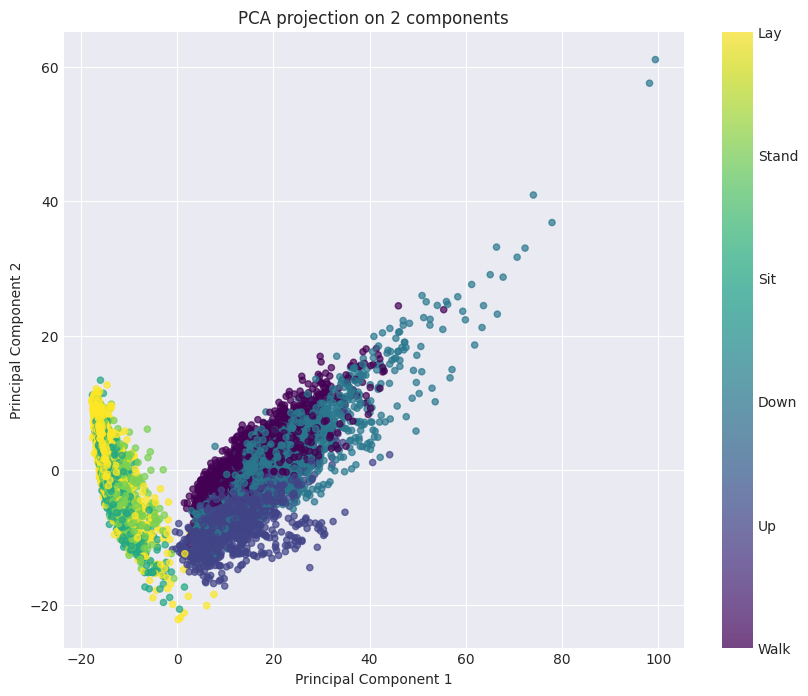

In [15]:
# Ваш код здесь
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, cmap='viridis');
plt.title("PCA projection on 2 components");

**Вопрос 3:** (0.5 баллов)

Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

**Ответ:**
- 1 кластер: все 6 активностей
- **2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)**
- 3 кластера: (ходьба), (подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 6 кластеров

------------------------------

**Задание 1.** (1 балл)

Сделайте кластеризацию данных методом `KMeans` (собственная имплементация и готовая реализация), обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [17]:
# на всем готовом живем...
kmeans = KMeans(n_clusters=n_classes, n_init=100, random_state=RANDOM_STATE)
kmeans.fit(X_pca)
cluster_labels = kmeans.labels_

print("Распределение меток (sklearn):")
print(np.bincount(cluster_labels))



# попытка сделать свое, отечественное...
class SimpleKMeans:
    def __init__(self, n_clusters, max_iter=300, random_state=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state
        self.labels_ = None
        self.centroids = None

    def fit(self, X):
        np.random.seed(self.random_state)

        # рандомные точки из данных, как центры
        initial_indices = np.random.permutation(X.shape[0])[:self.n_clusters]
        self.centroids = X[initial_indices]

        for i in range(self.max_iter):
            # расстояние от точки до центроида
            distances = np.sqrt(((X[:, np.newaxis] - self.centroids[np.newaxis, :]) ** 2).sum(axis=2))

            new_labels = np.argmin(distances, axis=1)
            new_centroids = np.array([
                X[new_labels == k].mean(axis=0) if np.sum(new_labels == k) > 0 else self.centroids[k]
                for k in range(self.n_clusters)
            ])

            if np.allclose(self.centroids, new_centroids):
                break

            self.centroids = new_centroids
            self.labels_ = new_labels

        return self

my_kmeans = SimpleKMeans(n_clusters=n_classes, random_state=RANDOM_STATE)
my_kmeans.fit(X_pca)

print("\nРаспределение меток (My implementation):")
print(np.bincount(my_kmeans.labels_))

# Короче там что-то сильно результаты отличаются от готовой реализации
# Наверное это связано с тем, что я рандомно выбрал центры
# Ниже попытка улучшить ситуаци: несколько раз запущу с разными начальными точками.

# По итогу после запуска: сильно медленнее, но реально числа стали поближе к готовой реализации

class ImprovedKMeans:
    def __init__(self, n_clusters, max_iter=300, n_init=10, random_state=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.n_init = n_init
        self.random_state = random_state
        self.labels_ = None
        self.centroids = None

    def fit(self, X):
        np.random.seed(self.random_state)

        best_inertia = None
        best_labels = None
        best_centroids = None

        for i in range(self.n_init):
            indices = np.random.permutation(X.shape[0])[:self.n_clusters]
            centroids = X[indices]
            labels = None

            for _ in range(self.max_iter):
                # E-шаг
                distances = np.sqrt(((X[:, np.newaxis] - centroids[np.newaxis, :]) ** 2).sum(axis=2))
                labels = np.argmin(distances, axis=1)
                # M-шаг
                new_centroids = np.array([
                    X[labels == k].mean(axis=0) if np.sum(labels == k) > 0 else centroids[k]
                    for k in range(self.n_clusters)
                ])

                if np.allclose(centroids, new_centroids):
                    break
                centroids = new_centroids

            # подсчет инерции, чтобы выбрать лучшую модель
            final_distances = np.sqrt(((X[:, np.newaxis] - centroids[np.newaxis, :]) ** 2).sum(axis=2))
            min_distances = np.min(final_distances, axis=1)
            inertia = np.sum(min_distances ** 2)

            # Если это первая попытка или нашли вариант лучше
            if best_inertia is None or inertia < best_inertia:
                best_inertia = inertia
                best_labels = labels
                best_centroids = centroids

        self.labels_ = best_labels
        self.centroids = best_centroids
        return self

improved_kmeans = ImprovedKMeans(n_clusters=n_classes, n_init=100, random_state=RANDOM_STATE)
improved_kmeans.fit(X_pca)
print("Распределение меток (My implementation after improve):")
print(np.bincount(improved_kmeans.labels_))

Распределение меток (sklearn):
[2631 2470 1927  279 1343 1649]

Распределение меток (My implementation):
[1530 3140 1666 1643 2027  293]
Распределение меток (My implementation after improve):
[2465 2631  279 1343 1649 1932]


Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

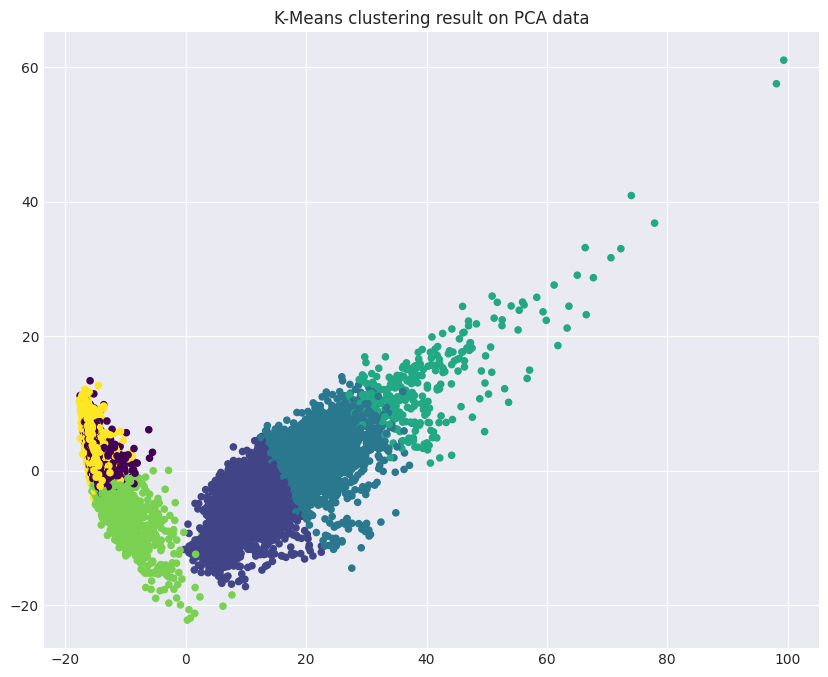

In [19]:
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, s=20, cmap='viridis');
plt.title("K-Means clustering result on PCA data");

Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [21]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице',
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,0,903,741,78,0,0,1722
подъем вверх по лестнице,0,1241,296,5,2,0,1544
спуск по лестнице,0,320,890,196,0,0,1406
сидение,1235,1,0,0,450,91,1777
стояние,1344,0,0,0,562,0,1906
лежание,52,5,0,0,329,1558,1944
все,2631,2470,1927,279,1343,1649,10299


Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации.

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,

то такая доля будет 900 / 1406 $\approx$ 0.64.


**Вопрос 4:** (1 балл)

Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

**Ответ:**
- ходьба
- стояние
- спуск по лестнице
- **перечисленные варианты не подходят** (если не ошибся в подсчетах, то: ходьба = 903/1722≈0.52; стояние = 1344/1906≈0.70; спуск = 890/1406≈0.63; лежание = 1558/1944≈0.80; подъем по лестнице = 1241/1544≈0.80)

Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.

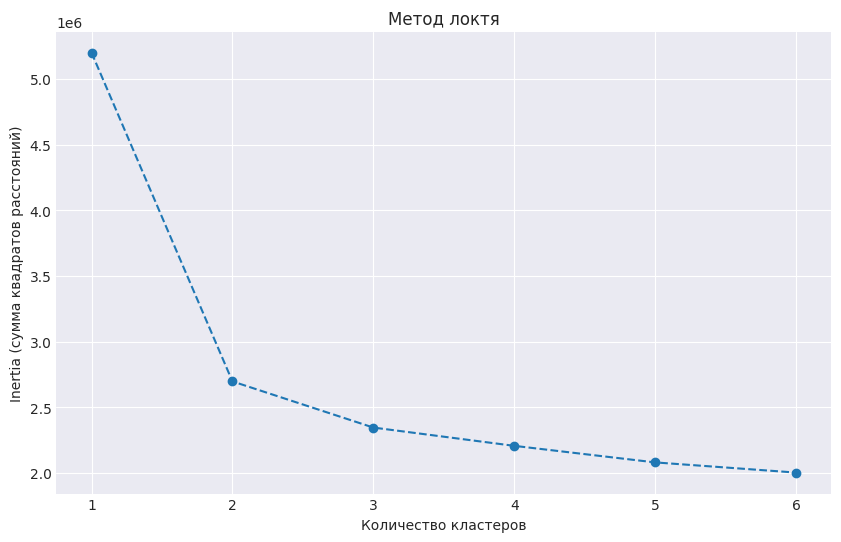

In [37]:
# Ваш код здесь
inertia = []
#for k in tqdm_notebook(range(1, n_classes + 1)):
for k in range(1, n_classes + 1):
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=RANDOM_STATE)
    kmeans.fit(X_pca)

    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, n_classes + 1), inertia, marker='o', linestyle='--')
plt.xlabel('Количество кластеров')
plt.ylabel('Inertia (сумма квадратов расстояний)')
plt.title('Метод локтя')
plt.show()

**Вопрос 5:** (1 балл)

Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

**Ответ:**
- 1
- **2** (падение самое резкое)
- 3
- 4

------------------------

Попробуем (**ну давай попробуем чО**) еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

In [23]:
ag = AgglomerativeClustering(n_clusters=n_classes,
                             linkage='ward').fit(X_pca)

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

In [24]:
# Ваш код здесь
ag = AgglomerativeClustering(n_clusters=n_classes, linkage='ward').fit(X_pca)

ag_score = metrics.adjusted_rand_score(y, ag.labels_)
print(f"ARI for Agglomerative Clustering: {ag_score:.4f}")

kmeans_score = metrics.adjusted_rand_score(y, cluster_labels)
print(f"ARI for KMeans: {kmeans_score:.4f}")

ARI for Agglomerative Clustering: 0.4936
ARI for KMeans: 0.4198


**Вопрос 6:** (1 балл)

Отметьте все верные утверждения.<br>

**Варианты:**
- **Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering**
- **Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры**
- **В случае случайного разбиения на кластеры ARI будет близок к нулю**

-------------------------------

Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Давайте теперь решим задачу классификации, вспомнив, что данные у нас размечены.  

Для классификации используйте метод опорных векторов – класс `sklearn.svm.LinearSVC`. Мы в курсе отдельно не рассматривали этот алгоритм, но он очень известен, почитать про него можно, например, в материалах Евгения Соколова –  [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf).

Настройте для `LinearSVC` гиперпараметр `C` с помощью `GridSearchCV`.

- Обучите новый `StandardScaler` на обучающей выборке (со всеми исходными признаками), прмиените масштабирование к тестовой выборке
- В `GridSearchCV` укажите  cv=3.

In [31]:
# Ваш код здесь
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train shape: {X_train_scaled.shape}, Test shape: {X_test_scaled.shape}")

Train shape: (7352, 561), Test shape: (2947, 561)


In [26]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [32]:
# Запускаем перебор параметров
best_svc = GridSearchCV(svc, svc_params, cv=3, n_jobs=-1)
best_svc.fit(X_train_scaled, y_train)

my_boy = best_svc.best_estimator_

In [34]:
print(f"Best params found: {best_svc.best_params_}")
print(f"Best CV score: {best_svc.best_score_:.4f}")

y_predicted = best_svc.predict(X_test_scaled)
test_score = metrics.accuracy_score(y_test, y_predicted)

print(f"Accuracy on Test set: {test_score:.4f}")

final_acc = my_boy.score(X_test_scaled, y_test)
print(f"Итоговая точность на тесте: {final_acc:.3f}")

Best params found: {'C': 0.1}
Best CV score: 0.9380
Accuracy on Test set: 0.9620
Итоговая точность на тесте: 0.962


**Вопрос 7** (0.5 баллов)

Какое значение гиперпараметра `C` было выбрано лучшим по итогам кросс-валидации?<br>

**Ответ:**
- 0.001
- 0.01
- **0.1**
- 1
- 10

In [35]:
y_predicted = best_svc.predict(X_test_scaled)

In [36]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице',
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,494,2,0,0,0,0,496
подъем вверх по лестнице,12,459,0,0,0,0,471
спуск по лестнице,2,4,413,1,0,0,420
сидение,0,4,0,426,61,0,491
стояние,0,0,0,15,517,0,532
лежание,0,0,0,0,11,526,537
все,508,469,413,442,589,526,2947


**Вопрос 8:** (0.5 балл)

Какой вид активности SVM определяет хуже всего в терминах точности? Полноты? <br>

**Ответ:**
- по точности – подъем вверх по лестнице, по полноте – лежание
- по точности – лежание, по полноте – сидение
- по точности – ходьба, по полноте – ходьба
- **по точности – сидение, по полноте – стояние**

Наконец, проделайте то же самое, что в 7 вопросе, только добавив PCA.

- Используйте выборки `X_train_scaled` и `X_test_scaled`
- Обучите тот же PCA, что раньше, на отмасшабированной обучающей выборке, примените преобразование к тестовой
- Настройте гиперпараметр `C` на кросс-валидации по обучающей выборке с PCA-преобразованием. Вы заметите, насколько это проходит быстрее, чем раньше.

**Вопрос 9:** (1 балл)

Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.<br>

**Варианты:**
- Качество одинаковое
- 2%
- 4%
- 10%
- 20%


**Вопрос 10:** (1 балл)

Выберите все верные утверждения:

**Варианты:**
- Метод главных компонент в данном случае позволил уменьшить время обучения модели, при этом качество (доля верных ответов на кросс-валидации) очень пострадало, более чем на 10%
- PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность
- PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком

**Задание 2.** (1 балл)

Попробуйте использовать DBSCAN в качестве алгоритма кластеризации и метод понижения размерности tSNE.